## Project Overview

This project analyzes SEPTA’s published GTFS schedule data to develop operational KPIs and service performance insights.

In [2]:
import os
import io
import zipfile
import requests
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

## 1. Download SEPTA GTFS Static Feed

In [ ]:
GTFS_URL = "https://www3.septa.org/developer/gtfs_public.zip"
OUT_DIR = "septa_gtfs"

os.makedirs(OUT_DIR, exist_ok=True)

print("Downloading GTFS data...")
response = requests.get(GTFS_URL, timeout=60)
response.raise_for_status()

print("Extracting files...")
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall(OUT_DIR)

print("Download and extraction complete.")

rail_zip_path = os.path.join(OUT_DIR, "google_rail.zip")
rail_out_dir = os.path.join(OUT_DIR, "rail")

os.makedirs(rail_out_dir, exist_ok=True)

with zipfile.ZipFile(rail_zip_path, 'r') as z:
    z.extractall(rail_out_dir)

print("Rail GTFS extracted.")

Extracting files...
Download and extraction complete.
Rail GTFS extracted.


In [6]:
os.listdir(rail_out_dir)

['agency.txt',
 'calendar.txt',
 'calendar_dates.txt',
 'directions.txt',
 'feed_info.txt',
 'routes.txt',
 'route_stops.txt',
 'shapes.txt',
 'stops.txt',
 'stop_times.txt',
 'trips.txt']

## 2. Load Core GTFS Tables

In [8]:
routes = pd.read_csv(os.path.join(rail_out_dir, "routes.txt"))
trips = pd.read_csv(os.path.join(rail_out_dir, "trips.txt"))
stop_times = pd.read_csv(os.path.join(rail_out_dir, "stop_times.txt"))
stops = pd.read_csv(os.path.join(rail_out_dir, "stops.txt"))
calendar = pd.read_csv(os.path.join(rail_out_dir, "calendar.txt"))

calendar_path = os.path.join(OUT_DIR, "calendar.txt")
calendar_dates_path = os.path.join(OUT_DIR, "calendar_dates.txt")

calendar = pd.read_csv(calendar_path) if os.path.exists(calendar_path) else None
calendar_dates = pd.read_csv(calendar_dates_path) if os.path.exists(calendar_dates_path) else None

## 3. Initial Data Inspection

In [10]:
print("routes:", routes.shape)
print("trips:", trips.shape)
print("stop_times:", stop_times.shape)
print("stops:", stops.shape)
print("calendar:", None if calendar is None else calendar.shape)
print("calendar_dates:", None if calendar_dates is None else calendar_dates.shape)

routes: (13, 9)
trips: (1093, 7)
stop_times: (16323, 10)
stops: (156, 7)
calendar: None
calendar_dates: None


In [11]:
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,AIR,SEPTA,AIR,Airport Line,NaN,2,https://www.septa.org/schedules/AIR,45637A,FFFFFF
1,WAR,SEPTA,WAR,Warminster Line,NaN,2,https://www.septa.org/schedules/WAR,45637A,FFFFFF
2,WIL,SEPTA,WIL,Wilmington/Newark Line,NaN,2,https://www.septa.org/schedules/WIL,45637A,FFFFFF
3,MED,SEPTA,MED,Media/Wawa Line,NaN,2,https://www.septa.org/schedules/MED,45637A,FFFFFF
4,WTR,SEPTA,WTR,West Trenton Line,NaN,2,https://www.septa.org/schedules/WTR,45637A,FFFFFF


In [12]:
trips.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,CYN,SID185189,CYN1052_20260201_SID185189,Suburban Station,0,1052,1005
1,CYN,SID185189,CYN1055_20260201_SID185189,Cynwyd,1,1055,5001
2,CYN,SID185189,CYN1056_20260201_SID185189,Suburban Station,0,1056,1005
3,CYN,SID185189,CYN1059_20260201_SID185189,Cynwyd,1,1059,5001
4,CYN,SID185189,CYN1060_20260201_SID185189,Suburban Station,0,1060,1005


In [13]:
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,CYN1052_20260201_SID185189,06:00:00,06:00:00,90001,1,Center City Philadelphia,NaN,NaN,NaN,1
1,CYN1052_20260201_SID185189,06:02:00,06:02:00,90002,2,Center City Philadelphia,NaN,NaN,NaN,1
2,CYN1052_20260201_SID185189,06:05:00,06:05:00,90003,3,Center City Philadelphia,NaN,NaN,NaN,1
3,CYN1052_20260201_SID185189,06:17:00,06:17:00,90004,4,Suburban Station,NaN,NaN,NaN,1
4,CYN1052_20260201_SID185189,06:22:00,06:22:00,90005,5,Suburban Station,NaN,NaN,NaN,1


## 4. Data Modeling and Table Integration

GTFS data is structured across multiple relational tables. 
To conduct route-level and system-level service analysis, these tables must be joined to create a unified analytical dataset.

The key relationships are:

- `routes` → defines high-level service lines
- `trips` → represents individual scheduled trips for each route
- `stop_times` → defines stop-level timing for each trip

To enable KPI development, we will:

1. Join routes to trips to attach route metadata to each trip.
2. Calculate stop counts per trip to measure trip complexity.
3. Extract the first departure time per trip to analyze service distribution by time of day.

The resulting dataset will serve as the core fact table for operational reporting and dashboard development.

In [14]:
route_trips = trips.merge(
    routes,
    on="route_id",
    how="left"
)

print(route_trips.shape)
route_trips.head()

(1093, 15)


,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,CYN,SID185189,CYN1052_20260201_SID185189,Suburban Station,0,1052,1005,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF
1,CYN,SID185189,CYN1055_20260201_SID185189,Cynwyd,1,1055,5001,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF
2,CYN,SID185189,CYN1056_20260201_SID185189,Suburban Station,0,1056,1005,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF
3,CYN,SID185189,CYN1059_20260201_SID185189,Cynwyd,1,1059,5001,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF
4,CYN,SID185189,CYN1060_20260201_SID185189,Suburban Station,0,1060,1005,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF


In [15]:
stops_per_trip = (
    stop_times
    .groupby("trip_id")
    .size()
    .reset_index(name="stop_count")
)

stops_per_trip.head()

,trip_id,stop_count
0,AIR2409_20260201_SID185186,8
1,AIR2413_20260201_SID185186,8
2,AIR2417_20260201_SID185186,8
3,AIR2421_20260201_SID185186,8
4,AIR2425_20260201_SID185186,8


In [16]:
route_trips = route_trips.merge(
    stops_per_trip,
    on="trip_id",
    how="left"
)

route_trips.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,stop_count
0,CYN,SID185189,CYN1052_20260201_SID185189,Suburban Station,0,1052,1005,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF,5
1,CYN,SID185189,CYN1055_20260201_SID185189,Cynwyd,1,1055,5001,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF,5
2,CYN,SID185189,CYN1056_20260201_SID185189,Suburban Station,0,1056,1005,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF,5
3,CYN,SID185189,CYN1059_20260201_SID185189,Cynwyd,1,1059,5001,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF,5
4,CYN,SID185189,CYN1060_20260201_SID185189,Suburban Station,0,1060,1005,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF,5


In [17]:
first_departure = (
    stop_times
    .sort_values("stop_sequence")
    .groupby("trip_id")
    .first()
    .reset_index()[["trip_id", "departure_time"]]
)

first_departure.head()

,trip_id,departure_time
0,AIR2409_20260201_SID185186,06:25:00
1,AIR2413_20260201_SID185186,07:25:00
2,AIR2417_20260201_SID185186,08:25:00
3,AIR2421_20260201_SID185186,09:25:00
4,AIR2425_20260201_SID185186,10:25:00


In [20]:
route_trips = route_trips.merge(
    first_departure,
    on="trip_id",
    how="left"
)

route_trips.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,stop_count,departure_time_x,departure_time_y,departure_time
0,CYN,SID185189,CYN1052_20260201_SID185189,Suburban Station,0,1052,1005,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF,5,06:00:00,06:00:00,06:00:00
1,CYN,SID185189,CYN1055_20260201_SID185189,Cynwyd,1,1055,5001,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF,5,06:46:00,06:46:00,06:46:00
2,CYN,SID185189,CYN1056_20260201_SID185189,Suburban Station,0,1056,1005,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF,5,07:28:00,07:28:00,07:28:00
3,CYN,SID185189,CYN1059_20260201_SID185189,Cynwyd,1,1059,5001,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF,5,08:10:00,08:10:00,08:10:00
4,CYN,SID185189,CYN1060_20260201_SID185189,Suburban Station,0,1060,1005,SEPTA,CYN,Cynwyd Line,NaN,2,https://www.septa.org/schedules/CYN,45637A,FFFFFF,5,08:46:00,08:46:00,08:46:00


In [21]:
route_trips.shape


(1093, 19)

In [22]:
def extract_hour(time_str):
    try:
        return int(time_str.split(":")[0])
    except:
        return None

route_trips["departure_hour"] = route_trips["departure_time"].apply(extract_hour)

route_trips[["departure_time", "departure_hour"]].head()

,departure_time,departure_hour
0,06:00:00,6
1,06:46:00,6
2,07:28:00,7
3,08:10:00,8
4,08:46:00,8


In [23]:
route_trips["departure_hour"].describe()

count    1093.000000
mean       13.436414
std         5.407974
min         3.000000
25%         9.000000
50%        14.000000
75%        18.000000
max        24.000000
Name: departure_hour, dtype: float64

In [24]:
trips_per_hour = (
    route_trips
    .groupby("departure_hour")
    .size()
    .reset_index(name="trip_count")
    .sort_values("departure_hour")
)

trips_per_hour

,departure_hour,trip_count
0,3,2
1,4,18
2,5,45
3,6,65
4,7,72
5,8,64
6,9,59
7,10,57
8,11,54
9,12,55


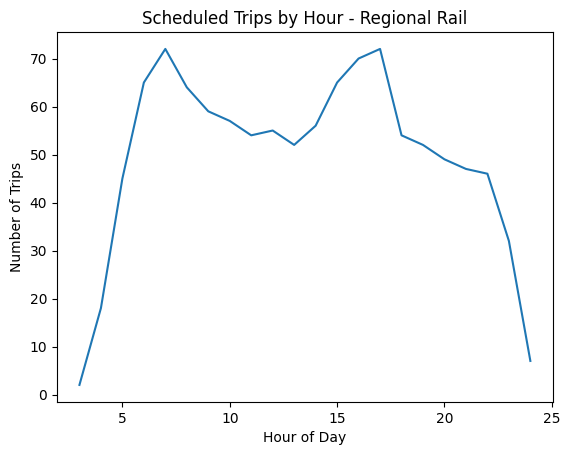

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(trips_per_hour["departure_hour"], trips_per_hour["trip_count"])
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.title("Scheduled Trips by Hour - Regional Rail")
plt.show()

In [26]:
def classify_peak(hour):
    if hour is None:
        return "Unknown"
    elif 6 <= hour <= 9:
        return "AM Peak"
    elif 16 <= hour <= 19:
        return "PM Peak"
    else:
        return "Off-Peak"

route_trips["service_period"] = route_trips["departure_hour"].apply(classify_peak)

route_trips[["departure_hour", "service_period"]].head()

,departure_hour,service_period
0,6,AM Peak
1,6,AM Peak
2,7,AM Peak
3,8,AM Peak
4,8,AM Peak


In [27]:
period_summary = (
    route_trips
    .groupby("service_period")
    .size()
    .reset_index(name="trip_count")
)

period_summary

,service_period,trip_count
0,AM Peak,260
1,Off-Peak,585
2,PM Peak,248


In [30]:
total_trips = len(route_trips)

peak_trips = route_trips[
    route_trips["service_period"].isin(["AM Peak", "PM Peak"])
].shape[0]

peak_service_ratio = peak_trips / total_trips

peak_service_ratio_pct = round(peak_service_ratio * 100, 2)
peak_service_ratio_pct


46.48

In [31]:
am_peak = route_trips[route_trips["service_period"] == "AM Peak"].shape[0]
pm_peak = route_trips[route_trips["service_period"] == "PM Peak"].shape[0]

print("AM Peak Trips:", am_peak)
print("PM Peak Trips:", pm_peak)

AM Peak Trips: 260
PM Peak Trips: 248


In [32]:
trips_per_route = (
    route_trips
    .groupby("route_short_name")
    .size()
    .reset_index(name="trip_count")
    .sort_values("trip_count", ascending=False)
)

trips_per_route.head(10)

,route_short_name,trip_count
0,AIR,156
8,PAO,124
5,LAN,97
10,WAR,96
7,NOR,92
9,TRE,90
6,MED,89
4,FOX,80
2,CHW,72
11,WIL,64


In [33]:
airport_trips = route_trips[route_trips["route_short_name"] == "AIR"]

airport_period_summary = (
    airport_trips
    .groupby("service_period")
    .size()
    .reset_index(name="trip_count")
)

airport_period_summary

,service_period,trip_count
0,AM Peak,32
1,Off-Peak,92
2,PM Peak,32


In [34]:
route_peak_summary = (
    route_trips
    .assign(is_peak=route_trips["service_period"].isin(["AM Peak", "PM Peak"]))
    .groupby("route_short_name")
    .agg(
        total_trips=("trip_id", "count"),
        peak_trips=("is_peak", "sum")
    )
)

route_peak_summary["peak_ratio"] = (
    route_peak_summary["peak_trips"] / route_peak_summary["total_trips"]
)

route_peak_summary.sort_values("peak_ratio", ascending=False).head(10)

,total_trips,peak_trips,peak_ratio
route_short_name,,,
CYN,12,8,0.666667
NOR,92,47,0.510870
MED,89,45,0.505618
LAN,97,49,0.505155
PAO,124,62,0.500000
WIL,64,29,0.453125
CHE,60,27,0.450000
WAR,96,43,0.447917
CHW,72,32,0.444444


In [35]:
service_intensity = (
    route_trips
    .groupby(["route_short_name", "departure_hour"])
    .size()
    .reset_index(name="trip_count")
)

service_intensity.sort_values("trip_count", ascending=False).head(10)

,route_short_name,departure_hour,trip_count
155,PAO,14,10
157,PAO,16,10
147,PAO,6,10
151,PAO,10,9
159,PAO,18,9
1,AIR,5,8
3,AIR,7,8
2,AIR,6,8
16,AIR,20,8
9,AIR,13,8


## Exporting CSVs to move to Power BI

In [36]:
fact_trips = route_trips[[
    "trip_id",
    "route_id",
    "route_short_name",
    "route_long_name",
    "departure_time",
    "departure_hour",
    "service_period",
    "stop_count"
]]

fact_trips.to_csv("fact_trips.csv", index=False)

In [37]:
route_summary = (
    route_trips
    .assign(is_peak=route_trips["service_period"].isin(["AM Peak", "PM Peak"]))
    .groupby("route_short_name")
    .agg(
        total_trips=("trip_id", "count"),
        peak_trips=("is_peak", "sum")
    )
    .reset_index()
)

route_summary["peak_ratio"] = (
    route_summary["peak_trips"] / route_summary["total_trips"]
)

route_summary.to_csv("route_summary.csv", index=False)

In [38]:
hourly_summary = (
    route_trips
    .groupby("departure_hour")
    .size()
    .reset_index(name="trip_count")
)

hourly_summary.to_csv("hourly_summary.csv", index=False)